## Different imports and setup

In [26]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import bz2
import json
import re
from tqdm.notebook import tqdm

# Milestone 1




## Functions

In [2]:
def create_frame(filename, N):
  """ Creates a DataFrame with the N first rows of the file with filename 
      It is useful to load small portions and test things.            """
  list_of_dicts = []
  with bz2.open(filename, 'rb') as s_file:
      for i, instance in enumerate(s_file):
        if (i>N-1):
            break
        instance = json.loads(instance) # loading a sample
        list_of_dicts.append(instance)
      
  return pd.DataFrame(list_of_dicts)
        

In [3]:
def retrieve_day(Date):
  """ Retrieve the day from a date with format 'YYYY-MM-DD hh:mm:ss' where Y is years, M months, D day, h hours,
      m minut and s seconds 
      Needs the following import :
      from datetime import datetime
      """

  try:                        
    date = datetime.strptime(Date, '%Y-%m-%d %H:%M:%S') # Convert to a datetime object and check that the format is correct and the numbers are valid
  except ValueError:
    raise ValueError('The string \'' + Date + '\' does not match the format \'YYYY-MM-DD hh:mm:ss\'') from None # Customize the error message

  if (date.year not in [2015, 2016, 2017, 2018, 2019, 2020]): # Check that the year is in the correct interval and that we do not have wrong data
    raise ValueError(f'The year {date.year} that you provided is not between 2015 and 2020 (inclusive).')

  weekday = datetime.isoweekday(date) # Obtain the weekday from 1 (monday) to 7 (sunday)

  # There are no switch/case statement in Python <= 3.10...
  if (weekday == 1):
    return 'Monday'
  elif (weekday == 2):
    return 'Tuesday'
  elif (weekday == 3):
    return 'Wednesday'
  elif (weekday == 4):
    return 'Thursday'
  elif (weekday == 5):
    return 'Friday'
  elif (weekday == 6):
    return 'Saturday'
  else:
    return 'Sunday'

In [4]:
def qid_to_label(QID, labels):
    """ Return the label corresponding to the QID. Labels should be a dataframe loaded as :
    labels = pd.read_csv('wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')
    """
    try:
        label = labels.loc[QID]['Label']
    except:
        raise ValueError('The QID \'' + QID + '\' does not appear in the repertoire labels') from None

    return label

In [5]:
def speaker_to_attributes(QID, attributes):
    """ Return the attributes corresponding to the QID of a speaker. Attributes should be a dataframe loaded as :
    attributes = pd.read_parquet('speaker_attributes.parquet')
    """
    line = attributes[attributes.id == QID]
    if (len(line) == 0):
        raise ValueError('The QID \'' + QID + '\' does not appear in the repertoire attributes') from None
    
    return line[['date_of_birth', 'nationality', 'gender', 'ethnic_group', 'occupation', 'party', 'religion']].to_dict(
        orient='records')[0]

In [6]:
def speaker_to_labels(QID, attributes, labels):
    """ Return the attributes corresponding to the QID of a speaker, readable by a human (not with QIDS).
    Attributes and labels should be dataframes loaded as :
    attributes = pd.read_parquet('speaker_attributes.parquet')
    labels = pd.read_csv('wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')
    """
    dic = speaker_to_attributes(QID, attributes)
    keys = ['nationality', 'gender', 'ethnic_group', 'occupation', 'party', 'religion']
    if (dic['date_of_birth'] is not None):
        dic['date_of_birth'] = dic['date_of_birth'][0]  # Reduce from list of 1 string to string
    for key in keys:
        if (dic[key] is not None):
            if (len(dic[key]) == 1):
                dic[key] = qid_to_label(dic[key][0], labels) # Reduce from list of 1 object to object
            else:
                new_value = []
                for q in dic[key]:
                    new_value.append(qid_to_label(q, labels))
                dic[key] = new_value
            
    return dic

In [7]:
def find_word(quote, lexic):
    """ Finds if any of the words in lexic are present in quote """
    for word in lexic:
        if(re.search(rf'\b{word}\b', quote, flags=re.IGNORECASE)):
            return True
    return False

In [8]:
def test(date):
    """ to use as a df.apply to remove speaker too old in the parquet file """
    if (date is not None):
        if (int(date[0][0:5].replace('+', '')) > 1900):
            return True
        else:
            return False
    else:
        return True


# Creates new datasets

In [ ]:
years = [2015, 2016, 2017, 2018, 2019, 2020]

for year in tqdm(years):

  path_to_file = f'Quotebank/quotes-{year}.json.bz2' 
  path_to_out = f'Quotebank_days/quotes-{year}.json.bz2'

  with bz2.open(path_to_file, 'rb') as s_file:
    with bz2.open(path_to_out, 'wb') as d_file:
      for instance in tqdm(s_file):
        instance = json.loads(instance) # loading a sample
        day = retrieve_day(instance['date'])
        instance['day'] = day
        d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file

In [9]:
lexic = ['climate', 'environment', 'environmental', 'global warming', 'oil', 'carbon', 'greenhouse effect', 'gas', 'fuel', 'renewable',
 'pollutant', 'ozone', 'methane', 'coal', 'emissions']
 # Atmosphere and ecosystem give A LOT of non-climate related quotes (lot of sort quotes use atmosphere, and ecosystem refers to companies)


lexic_small = ['climate change', 'climate emergency', 'global warming', 'COP21', 'COP26']

In [ ]:
path_to_file = 'Quotebank_days/quotes-2020.json.bz2' 
path_to_out = 'Quotebank_climate/quotes-2020.json.bz2'

with bz2.open(path_to_file, 'rb') as s_file:
    with bz2.open(path_to_out, 'wb') as d_file:
      for instance in tqdm(s_file):
        instance = json.loads(instance) # loading a sample
        if(find_word(instance['quotation'], lexic)):
          d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file

In [10]:
attributes = pd.read_parquet('speaker_attributes.parquet')

In [11]:
labels = pd.read_csv('wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')

In [12]:
path_to_file = 'Quotebank_days/quotes-2020.json.bz2' 
path_to_out = 'Quotebank_climate/quotes-2020.json.bz2'

keys = ['date_of_birth', 'nationality', 'gender', 'ethnic_group', 'occupation', 'party', 'religion']

with bz2.open(path_to_file, 'rb') as s_file:
  with bz2.open(path_to_out, 'wb') as d_file:
      for instance in tqdm(s_file):
        instance = json.loads(instance) # loading a sample
        if(find_word(instance['quotation'], lexic_small)):
          if (len(instance['qids']) == 1):
            try:
              dic = speaker_to_labels(instance['qids'][0], attributes, labels)
              for key in dic.keys():
                instance[key] = dic[key]
            except:
              pass
          else:
            for key in keys:
              instance[key] = None
          d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file

0it [00:00, ?it/s]

# Experiment with datasets

In [35]:
quotes = pd.read_json('Quotebank_climate/quotes-2020.json.bz2', compression='bz2', lines=True)
quotes.fillna('None', inplace=True)

In [36]:
quotes['count'] = len(quotes)

In [44]:
gender = quotes['gender']

6

In [54]:
for i in range(len(quotes)):
    if (type(gender[i]) == list):
        print(i)

8015


In [55]:
gender[8015]

['non-binary', 'transgender person']

<AxesSubplot:>

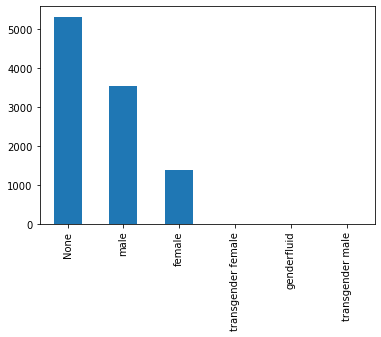

In [63]:
quotes['gender'].value_counts().plot.bar()

In [62]:
plt.figure()
sns.barplot(data=quotes['gender'].value_counts(), x='gender')

ValueError: Could not interpret input 'gender'

<Figure size 432x288 with 0 Axes>

In [ ]:
pd.set_option("display.max_colwidth", 20000)
pd.set_option('display.max_rows', 5000)
quote.head(10)